In [1]:
import os
import pandas as pd
import matplotlib
import numpy as np
from scipy.stats import binom, chisquare, chi2, binom
from generate_data import Controller
import scipy
wd = os.path.dirname(os.getcwd())

/var/folders/f3/g1154c6d5hb7y4_s6bzsyw8m0000gn/T/ipykernel_66242/2087324212.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
no_mask = pd.read_csv(wd+'/data/no_mask_no_vacc_10k.csv')

# Question 1
What is the distribution of the number of kids that Tommy infects on Day 1?

First, pivot the raw data and return a dataframe that shows the number

In [3]:
def get_infected_count(day, df):
    df = df.loc[no_mask['day'] == day]
    pivot_tbl = pd.pivot_table(
        df,
        index=['contagious'],
        values='trial',
        aggfunc=["count"],
    ).reset_index()
    pivot_tbl.columns = ['contagious', 'count']
    pivot_tbl['percent'] = pivot_tbl['count']/pivot_tbl['count'].sum()
    return df, pivot_tbl


day_1_df, day_1_observed = get_infected_count(1, no_mask)
day_1_observed

,contagious,count,percent
0,1.0,5566,0.5566
1,2.0,3295,0.3295
2,3.0,941,0.0941
3,4.0,171,0.0171
4,5.0,25,0.0025
5,6.0,2,0.0002


Now, plot a histogram of the frequencies that the number of infected appears on each day.

<Axes: >

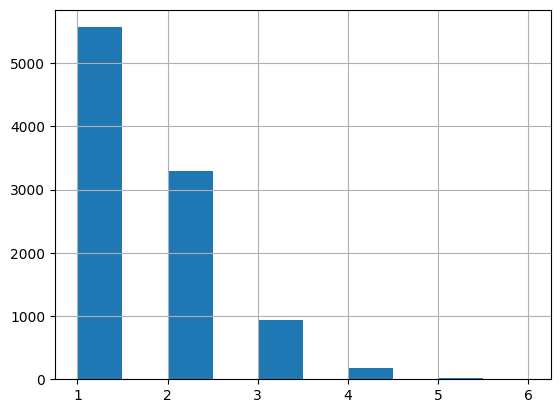

In [4]:
day_1_df['infected'].hist()

Now, plot what a binomial(30, .02) distribution would look like

<Axes: xlabel='bucket'>

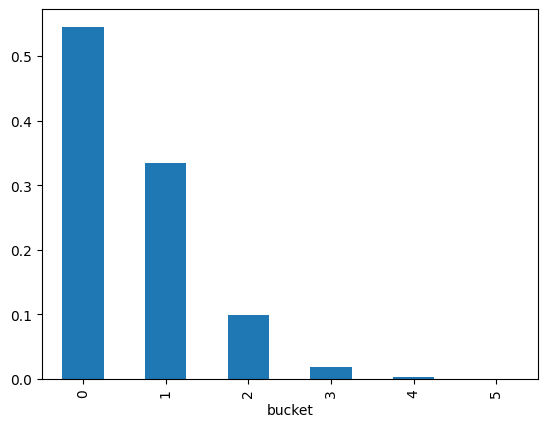

In [5]:
def binomial_buckets(n, p, k):
    df = pd.DataFrame()
    df['bucket'] = np.arange(n + 1)
    df['frequency'] = binom.pmf(np.arange(n + 1), n, p)
    df['frequency'] = df['frequency']
    df['population'] = round(df['frequency']*k,0)

    return df.set_index('bucket')

day_1_expected = binomial_buckets(30, .02, no_mask.trial.max()).loc[:5,:]

day_1_expected['frequency'].plot(kind='bar')


Visual inspection tells us our hypothesis may be correct, and to reject the null hypothesis that the distribution is not binoial(30, .02). To confirm this, we will do a chi squared test to confirm our hypothesis.

The sum of the population column may not equal the number of trials we had due to rounding, so we alter the last record to reflect the last bucket to have the remaining number of trials.

In [6]:
day_1_expected['population'].sum()

10000.0

In [7]:
observed = day_1_observed['count']
expected = day_1_expected['population'].astype(int)
chi_sq = chisquare(observed,expected)
print(f'Test Statistic: {round(chi_sq[0],2)} \nP-value = {round(chi_sq[1],2)}')

Test Statistic: 7.01 
P-value = 0.22


In [8]:
crit_val = chi2.ppf(1-.05, 6)
print(f'Critical x^2 value = {crit_val}')

Critical x^2 value = 12.591587243743977


The Chi Square test statistic is less than the significant value at a .05% confidence level, and the p-value is greater than .05. Thus, we fail to reject the null hypothesis that the distirbution of students infected on day 1 is distributed as binomial(30, .02)

# Question 2
What is the expected number of kids that Tommy infects on Day 1?

The expected number of students Tommy infects on day one can be estimated using the simulation, by simply taking the average number of students infected on day 1 (where day 0 is the first day that Tommy came to school) across all trials. Note, this value includes Tommy himself as he is also infected on Day 1.

In [9]:
simulated_mean = day_1_df['contagious'].mean()
print(f'Average number of students infected on day 1: {simulated_mean}')

Average number of students infected on day 1: 1.58


This can also be calculated analytically, by using the expected value formula for a binomial distribution:
$$
E[X] = np
$$

Where n is the number of students and p is the probability of tommy infecting other students. Note, this value represent the new infections, so to include tommy we must add 1

In [10]:
true_mean = 30 * .02 + 1
print(f'Expected value of students infected on day 1: {true_mean}')

Expected value of students infected on day 1: 1.6


In [11]:
day_2_df, day_2_observed = get_infected_count(2, no_mask)

In [12]:
day_2_df['infected'].mean()

2.4593

In [13]:
day_2_observed

,contagious,count,percent
0,1.0,3080,0.3080
1,2.0,2903,0.2903
2,3.0,1961,0.1961
3,4.0,1094,0.1094
4,5.0,558,0.0558
5,6.0,240,0.0240
6,7.0,116,0.0116
7,8.0,31,0.0031
8,9.0,13,0.0013
9,10.0,3,0.0003


# Question 3
What is the expected number of kids that are infected by Day 2 (you can
count Tommy if you want)?

In [14]:
import math
def calc_exposure_probability(num_students_infected):
    infectiousness_rate = .02
    infected_students = [1-infectiousness_rate for i in range(num_students_infected)]
    students = infected_students
    exposure = 1 - math.prod(students)
    return exposure

def day_2_infected_prob_given_day_1(day_2_infected, day_1_infected):
    susceptible_students = 30-day_1_infected
    exposure = calc_exposure_probability(day_1_infected+1)
    day_2_prob = binom.pmf(k=day_2_infected,n=susceptible_students,p=exposure)
    return day_2_prob

def cum_prob_day_2(num_students):
    probability_list = []
    for s in range(num_students+1):
        day_1 = num_students-s
        day_2 = num_students-day_1
        prob_a_given_b = day_2_infected_prob_given_day_1(day_2,day_1)
        prob_a = binom.pmf(k=day_1,n=30,p=.02)
        prob_b = prob_a_given_b*prob_a
        probability_list.append(prob_b)
    return sum(probability_list)

data = []
for i in range(11):
    expected_day_2 = []
    additional_students_infected = i
    cumulative_probability = cum_prob_day_2(i)
    data.append({'infected_students': additional_students_infected,
                 'probability': cumulative_probability})
    expected_day_2.append(cumulative_probability)
expected_day_2 = pd.DataFrame(data)
expected_day_2['hfx'] = expected_day_2['probability'] * expected_day_2['infected_students']

In [15]:
expected_day_2

,infected_students,probability,hfx
0,0,0.297553,0.000000
1,1,0.285647,0.285647
2,2,0.195743,0.391486
3,3,0.115494,0.346483
4,4,0.059656,0.238622
5,5,0.027537,0.137685
6,6,0.011565,0.069388
7,7,0.004463,0.031238
8,8,0.001591,0.012732
9,9,0.000527,0.004739


In [16]:
expected_day_2['hfx'].sum() + 1 # plus 1 to include Tommy

1.5196409932865926

In [17]:
day_2_df['infected'].mean()

2.4593

# Question 4a


Simulate the number of kids that are infected on Days 1,2,. . . . Do this many
times. What are the (estimated) expected numbers of kids that are infected
by Day i, i = 1, 2, . . .?

In [18]:
no_mask.head(30)

,Unnamed: 0,trial,day,masked,vaccinated,infected,contagious,exposure
0,0,1.0,0.0,0.0,0.0,1.0,1.0,0.020000
1,1,1.0,1.0,0.0,0.0,3.0,3.0,0.058808
2,2,1.0,2.0,0.0,0.0,5.0,5.0,0.096079
3,3,1.0,3.0,0.0,0.0,9.0,6.0,0.114158
4,4,1.0,4.0,0.0,0.0,12.0,7.0,0.131874
5,5,1.0,5.0,0.0,0.0,17.0,8.0,0.149237
6,6,1.0,6.0,0.0,0.0,20.0,8.0,0.149237
7,7,1.0,7.0,0.0,0.0,22.0,5.0,0.096079
8,8,1.0,8.0,0.0,0.0,22.0,2.0,0.039600
9,9,1.0,9.0,0.0,0.0,22.0,0.0,0.000000


In [24]:

summary = pd.pivot_table(
    no_mask,
    index=['day'],
    values='contagious',
    aggfunc=['mean'],
).reset_index()
summary.columns = ['day', 'mean_infected']
summary

,day,mean_infected
0,0.0,1.0000
1,1.0,1.5800
2,2.0,2.4593
3,3.0,2.1579
4,4.0,2.2866
5,5.0,2.0095
6,6.0,1.7975
7,7.0,1.4483
8,8.0,1.1417
9,9.0,0.8544


# Question 4b
Create a histogram of how long the pandemic will last

In [19]:
pandemic_length = no_mask.loc[no_mask['contagious'] == 0]
pandemic_length = pd.pivot_table(
    pandemic_length,
    index=['trial'],
    values='day',
    aggfunc=["min"],
).reset_index()
pandemic_length.columns = ['trial', 'lastDay']
pandemic_length

,trial,lastDay
0,1.0,9.0
1,2.0,16.0
2,3.0,7.0
3,4.0,10.0
4,5.0,4.0
...,...,...
9995,9996.0,7.0
9996,9997.0,8.0
9997,9998.0,12.0
9998,9999.0,16.0


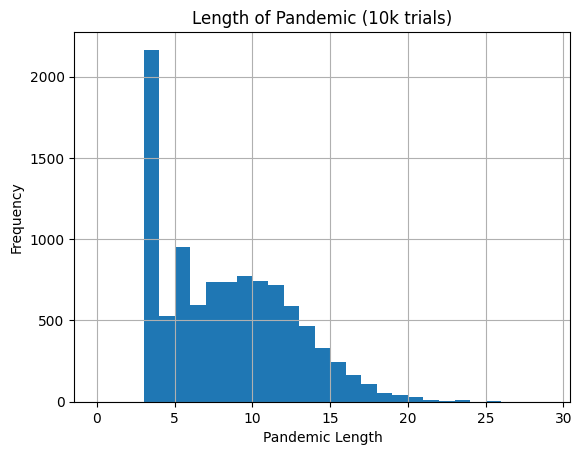

In [22]:
import matplotlib.pyplot as plt
plt.hist(pandemic_length['lastDay'], bins=range(30))  # Adjust the bins as needed
plt.xlabel('Pandemic Length')
plt.ylabel('Frequency')
plt.title('Length of Pandemic (10k trials)')
plt.grid(True)
# plt.show()


# Question 5
What if each kid has a 50-50 chance of being immunized?

Generate the data

In [28]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
file_path = parent_directory + '/data/50pcnt_vacc_10k.csv'

if not os.path.exists(file_path):
    sim = Controller(number_of_students=30,
                         vaccinated_percentage=.5,
                         vaccine_efficiency=1,
                         masked_percentage=0,
                         mask_effectiveness=.5,
                         infectiousness=.02,
                         sim_length=30,
                         num_trials=10000)

    sim.run_Simulation()
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    sim.sim_results.to_csv(file_path)

In [29]:
vacc_df = pd.read_csv(wd+'/data/50pcnt_vacc_10k.csv')

In [30]:
summary = pd.pivot_table(
    vacc_df,
    index=['day'],
    values='contagious',
    aggfunc=['mean'],
).reset_index()
summary.columns = ['day', 'mean_infected']
summary

,day,mean_infected
0,0.0,1.0000
1,1.0,1.2945
2,2.0,1.6585
3,3.0,0.8077
4,4.0,0.6458
5,5.0,0.3550
6,6.0,0.2286
7,7.0,0.1262
8,8.0,0.0746
9,9.0,0.0377


In [31]:
pandemic_length_vacc = vacc_df.loc[vacc_df['contagious'] == 0]
pandemic_length_vacc = pd.pivot_table(
    pandemic_length_vacc,
    index=['trial'],
    values='day',
    aggfunc=["min"],
).reset_index()
pandemic_length_vacc.columns = ['trial', 'lastDay']


,trial,lastDay
0,1.0,3.0
1,2.0,8.0
2,3.0,3.0
3,4.0,3.0
4,5.0,3.0
...,...,...
9995,9996.0,3.0
9996,9997.0,3.0
9997,9998.0,3.0
9998,9999.0,4.0


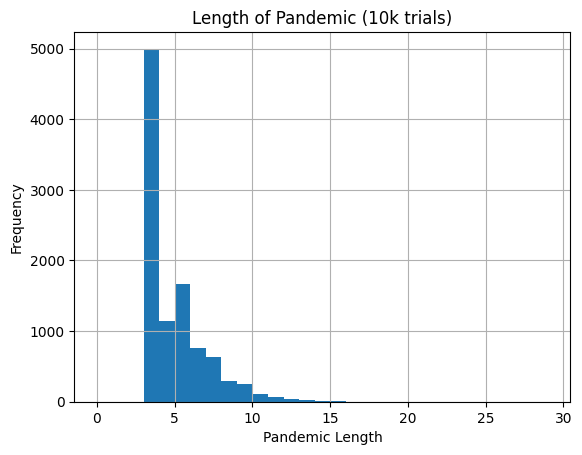

In [32]:
plt.hist(pandemic_length_vacc['lastDay'], bins=range(30))  # Adjust the bins as needed
plt.xlabel('Pandemic Length')
plt.ylabel('Frequency')
plt.title('Length of Pandemic (10k trials)')
plt.grid(True)